# Scraping de propiedades en mapainmueble.com

Este notebook realiza un scraping de propiedades de alquiler en el sitio **mapainmueble.com**.
Se recopilan detalles como título, enlace, imagen, ubicación, precio, número de habitaciones, baños, tamaño, y parqueos.

El código utiliza las siguientes bibliotecas:

- `requests`: Para realizar peticiones HTTP al sitio web.
- `BeautifulSoup`: Para analizar y extraer datos del HTML.
- `csv`: Para guardar los datos extraídos en un archivo CSV.
- `time`: Para manejar pausas entre peticiones y evitar bloqueos.

El scraping recorre varias páginas del sitio y obtiene la información de cada propiedad listada.



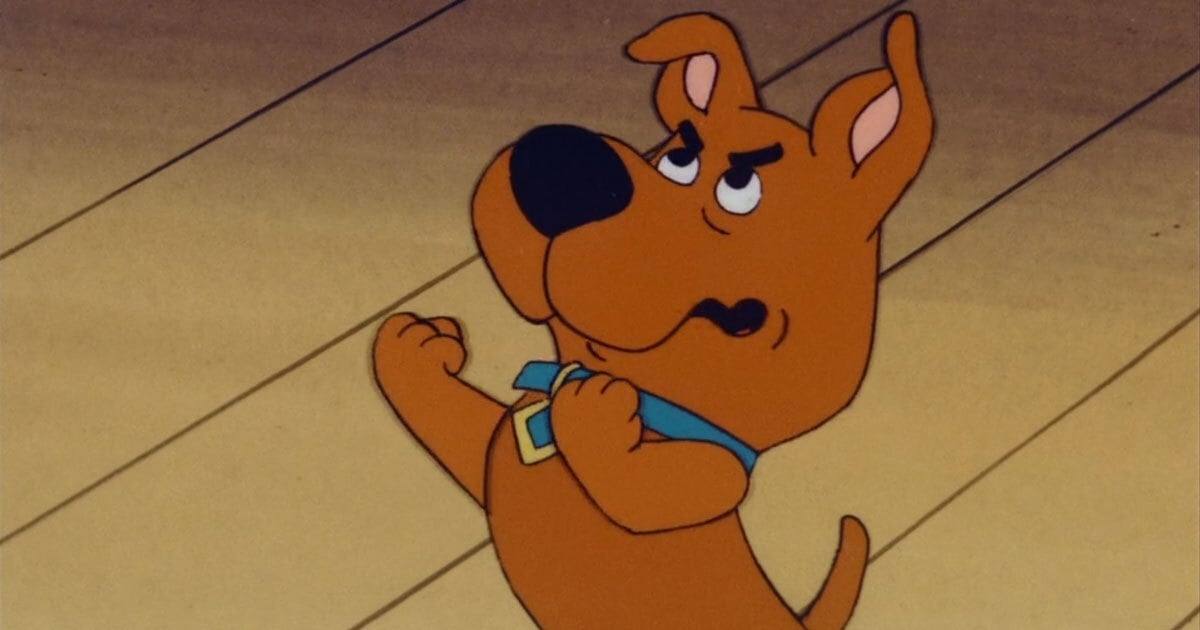


## Juan Diego Letona Aguilar, 20230285

In [1]:
import requests
from bs4 import BeautifulSoup
import csv

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
}

base_url = "https://mapainmueble.com/apartamentos-en-alquiler/"
paginas = [base_url] + [f"{base_url}page/{i}/" for i in range(2, 50)]

propiedades = []

In [3]:
for url in paginas:
    print("procesando página: " + url)
    try:
        resp = requests.get(url, headers=headers)
        resp.raise_for_status()
    except Exception as e:
        print("error al acceder a " + url + ": " + str(e))
        continue
    soup = BeautifulSoup(resp.text, "html.parser")
    items = soup.select("div.listing_wrapper")
    print("encontradas " + str(len(items)) + " propiedades en " + url)
    for item in items:
        try:
            prop_id = item.get("data-listid", "na").strip()
            titulo = item.get("data-modal-title", "na").strip()
            enlace = item.get("data-modal-link", "na").strip()
            imagen_principal = item.get("data-main-modal", "na").strip()
            media_div = item.select_one("div.property_media")
            camaras = media_div.get_text(strip=True) if media_div else "0"
            loc_div = item.select_one("div.property_location_image")
            area = "na"
            ciudad = "na"
            if loc_div:
                a_tags = loc_div.find_all("a")
                if len(a_tags) >= 1:
                    area = a_tags[0].get_text(strip=True)
                if len(a_tags) >= 2:
                    ciudad = a_tags[1].get_text(strip=True)
            precio_div = item.select_one("div.listing_unit_price_wrapper")
            precio = precio_div.get_text(strip=True) if precio_div else "na"
            desc_div = item.select_one("div.listing_details")
            descripcion = desc_div.get_text(strip=True) if desc_div else "na"
            details_div = item.select_one("div.property_listing_details")
            habitaciones = "na"
            banos = "na"
            tamano = "na"
            if details_div:
                span_habit = details_div.find("span", class_="inforoom")
                habitaciones = span_habit.get_text(strip=True) if span_habit else "na"
                span_bath = details_div.find("span", class_="infobath")
                banos = span_bath.get_text(strip=True) if span_bath else "na"
                span_size = details_div.find("span", class_="infosize")
                tamano = span_size.get_text(strip=True) if span_size else "na"
            parqueos = "0"
            if enlace != "na":
                try:
                    resp_det = requests.get(enlace, headers=headers)
                    resp_det.raise_for_status()
                    soup_det = BeautifulSoup(resp_det.text, "html.parser")
                    panel = soup_det.find("div", id="accordion_prop_details")
                    if panel:
                        detail_items = panel.find_all("div", class_="listing_detail")
                        for detail in detail_items:
                            strong_tag = detail.find("strong")
                            if strong_tag:
                                label = strong_tag.get_text(strip=True).replace(":", "").lower()
                                if label == "parqueos":
                                    text = detail.get_text(separator=" ", strip=True)
                                    parqueos = text.split(":")[-1].strip()
                                    break
                    else:
                        parqueos = "na"
                except Exception as e:
                    print("error al obtener detalles de " + enlace + ": " + str(e))
                    parqueos = "na"
            propiedades.append({
                "id": prop_id,
                "titulo": titulo,
                "enlace": enlace,
                "imagen_principal": imagen_principal,
                "camaras": camaras,
                "area": area,
                "ciudad": ciudad,
                "precio": precio,
                "descripcion": descripcion,
                "habitaciones": habitaciones,
                "banos": banos,
                "tamano": tamano,
                "parqueos": parqueos
            })
        except Exception as e:
            print("error al procesar propiedad: " + str(e))
            continue

procesando página: https://mapainmueble.com/apartamentos-en-alquiler/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler/page/2/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler/page/2/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler/page/3/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler/page/3/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler/page/4/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler/page/4/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler/page/5/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler/page/5/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler/page/6/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler/page/6/
procesando página: https://map

In [4]:
with open("propiedades.csv", "w", newline="", encoding="utf-8") as csvfile:
    campo_nombres = ["id", "titulo", "enlace", "imagen_principal", "camaras", "area", "ciudad", "precio", "descripcion", "habitaciones", "banos", "tamano", "parqueos"]
    writer = csv.DictWriter(csvfile, fieldnames=campo_nombres)
    writer.writeheader()
    for propiedad in propiedades:
        writer.writerow(propiedad)
print("scraping completado. datos guardados en 'propiedades.csv'.")

scraping completado. datos guardados en 'propiedades.csv'.


In [5]:
#Ahora para la limpieza

import csv
import re
import unicodedata

In [6]:
def clean_text(text):
    if not text:
        return ""
    text = unicodedata.normalize("NFKD", text)
    text = text.replace("\xa0", " ").strip()
    return text

In [7]:
def clean_price(price_text):
    if not price_text:
        return ""
    txt = price_text.upper()
    remove_phrases = [
        "VER DETALLES", "MÁS MANTENIMIENTO E IVA", "MÁS MANTENIMIENTO IVA",
        "MÁS MANTENIMIENTO", "+ IVA", "IVA", "MÁS", "$", "Q"
    ]
    for phrase in remove_phrases:
        txt = txt.replace(phrase, "")
    match = re.findall(r"[0-9.,]+", txt)
    if match:
        raw_price = match[0]
        raw_price = raw_price.replace(",", "")
        return raw_price.strip()
    return ""

In [8]:
def clean_area(area_text):
    if not area_text:
        return ""
    area_text = clean_text(area_text)
    match = re.search(r"[Zz]ona\s*(\d+)", area_text)
    if match:
        return match.group(1)
    return area_text

In [9]:
def clean_city(city_text):
    if not city_text:
        return ""
    city_text = clean_text(city_text)
    city_text = city_text.replace("*", "").strip()
    return city_text

In [10]:
def clean_size(size_text):
    if not size_text:
        return ""
    txt = clean_text(size_text)
    txt = re.sub(r"[Mm][2²]", "", txt)
    return txt.strip()

In [11]:
input_file = "propiedades.csv"
output_file = "propiedades_limpias.csv"

In [12]:
with open(input_file, "r", encoding="utf-8", newline="") as infile, \
     open(output_file, "w", encoding="utf-8", newline="") as outfile:

    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for row in reader:
        row["titulo"] = clean_text(row["titulo"])
        row["enlace"] = clean_text(row["enlace"])
        row["imagen_principal"] = clean_text(row["imagen_principal"])
        row["camaras"] = clean_text(row["camaras"])
        row["area"] = clean_area(row["area"])
        row["ciudad"] = clean_city(row["ciudad"])
        row["precio"] = clean_price(row["precio"])
        row["descripcion"] = clean_text(row["descripcion"])
        row["habitaciones"] = clean_text(row["habitaciones"])
        row["banos"] = clean_text(row["banos"])
        row["tamano"] = clean_size(row["tamano"])
        row["parqueos"] = clean_text(row["parqueos"])
        writer.writerow(row)

print(f"¡Proceso de limpieza completado!\nRevisa el archivo '{output_file}' para los datos limpios.")

¡Proceso de limpieza completado!
Revisa el archivo 'propiedades_limpias.csv' para los datos limpios.
